<a href="https://colab.research.google.com/github/NataGoto/predictive-maintenance/blob/main/Pumps_111_3_failures_and_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Визуализация предикта со днями промывки и сравнение с актуальными классами выделены одним цветом, но с разными маркерами - круги и звездочки**

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


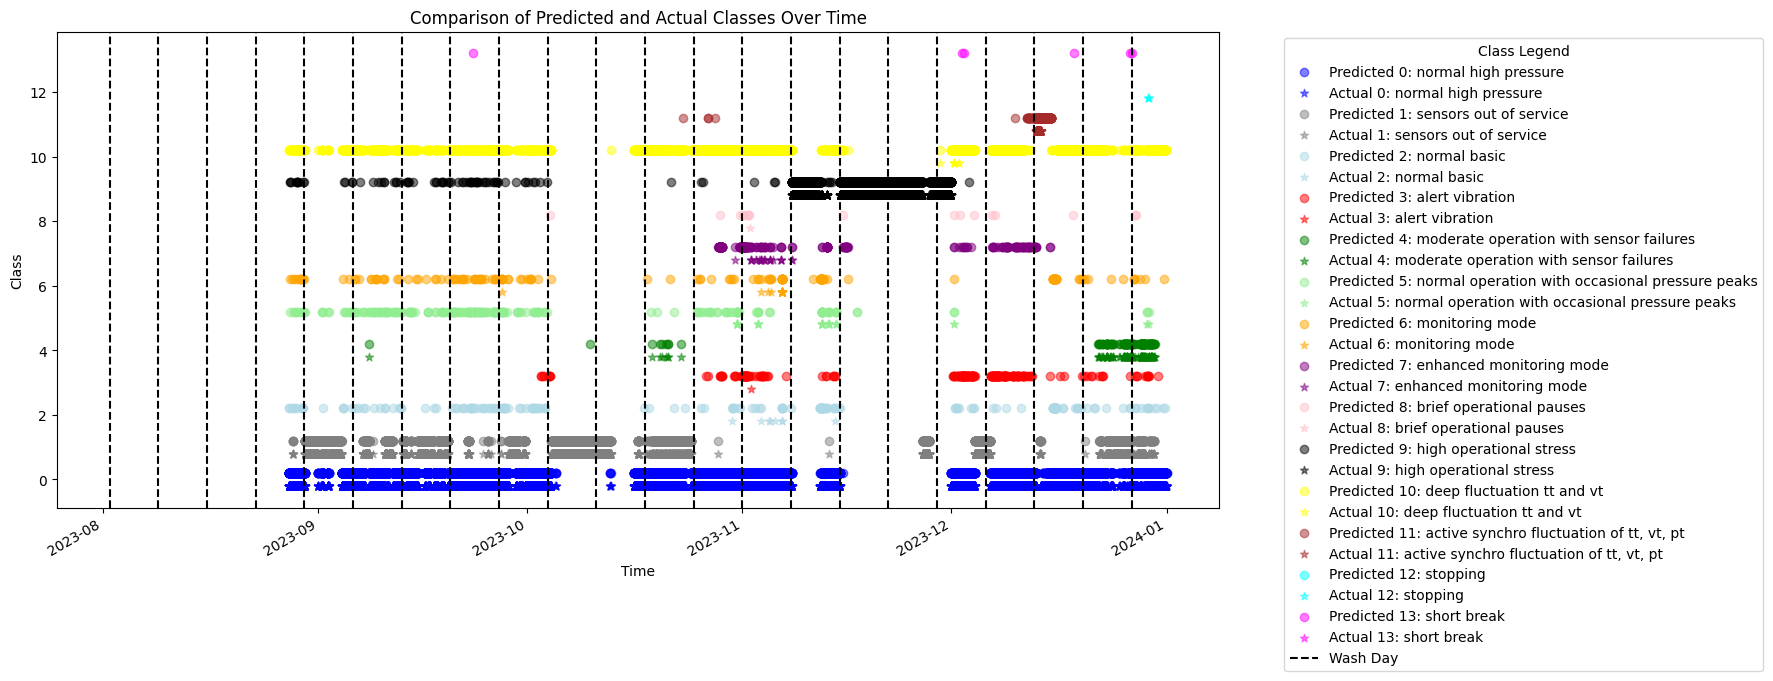

In [ ]:
import matplotlib.pyplot as plt
# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_classified_no_junk.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data['cluster'] = data['cluster'].astype(int)

features = ['P3-111/A_PT_341', 'P3-111/A_TT_341', 'P3-111/A_VT_341',
            'P3-111/A_VT_342', 'P3-111/A_VT_343', 'P3-111/B_PT_351',
            'P3-111/B_TT_351', 'P3-111/B_VT_351', 'P3-111/B_VT_352',
            'P3-111/B_VT_353', 'P3-111/C_PT_361', 'P3-111/C_TT_361',
            'P3-111/C_VT_361', 'P3-111/C_VT_363', 'P3-111/C_VT_362_scaled']
target = 'cluster'

# Отметка дней промывки в данных
wash_dates = [
    "2023-08-02", "2023-08-09", "2023-08-16", "2023-08-23", "2023-08-30",
    "2023-09-06", "2023-09-13", "2023-09-20", "2023-09-27",
    "2023-10-04", "2023-10-11", "2023-10-18", "2023-10-25",
    "2023-11-01", "2023-11-08", "2023-11-15", "2023-11-22", "2023-11-29",
    "2023-12-06", "2023-12-13", "2023-12-20", "2023-12-27"
]
wash_dates_dt = pd.to_datetime(wash_dates)
data['is_wash_day'] = pd.Index(data.index.date).isin(wash_dates_dt.date)

# Индикатор для датчиков вне сервиса
data['sensors_out_of_service'] = (data['cluster'] == 1).astype(int)

# Разделение данных на обучающую и тестовую выборку с сохранением индекса
X = data[features]
y = data[target]
timestamps = data.index

# Определение длины последовательности для LSTM
sequence_length = 60

# Подготовка данных для модели
X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
    X, y, timestamps, test_size=0.2, random_state=42
)


def create_sequences(X, y, timestamps, sequence_length=60):
    xs, ys, ts = [], [], []
    for i in range(len(X) - sequence_length + 1):  # Изменено условие для корректного создания последней последовательности
        xs.append(X.iloc[i:i + sequence_length].values)
        ys.append(y.iloc[i + sequence_length - 1])
        ts.append(timestamps[i + sequence_length - 1])  # Использование прямой индексации
    return np.array(xs), np.array(ys), np.array(ts)

X_train_seq, y_train_seq, train_timestamps = create_sequences(X_train, y_train, timestamps_train, sequence_length=60)
X_test_seq, y_test_seq, test_timestamps = create_sequences(X_test, y_test, timestamps_test, sequence_length=60)

results_df = pd.DataFrame({
    'timestamp': test_timestamps,
    'predicted_class': predicted_classes,
    'actual_class': y_test_seq  # Используем y_test_seq, который соответствует размеру X_test_seq
})
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
results_df.set_index('timestamp', inplace=True)

# Загрузка обученной модели и получение предсказаний
model_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\LSTM_new_weights.keras'
model = load_model(model_path)
predictions = model.predict(X_test_seq)
predicted_classes = np.argmax(predictions, axis=1)

# Визуализация
# Создание новой фигуры для избежания повторного использования старых объектов
fig, ax = plt.subplots(figsize=(15, 7))

# Сопоставление классов с цветами
color_map = {
    0: 'blue', 1: 'grey', 2: 'lightblue', 3: 'red', 4: 'green',
    5: 'lightgreen', 6: 'orange', 7: 'purple', 8: 'pink',
    9: 'black', 10: 'yellow', 11: 'brown', 12: 'cyan', 13: 'magenta'
}

# Словарь для описания классов
class_map = {
    0: "normal high pressure",
    1: "sensors out of service",
    2: "normal basic",
    3: "alert vibration",
    4: "moderate operation with sensor failures",
    5: "normal operation with occasional pressure peaks",
    6: "monitoring mode",
    7: "enhanced monitoring mode",
    8: "brief operational pauses",
    9: "high operational stress",
    10: "deep fluctuation tt and vt",
    11: "active synchro fluctuation of tt, vt, pt",
    12: "stopping",
    13: "short break"
}

# Отображение предсказанных и реальных классов
for cls in color_map:
    # Фильтрация данных по классу для предсказаний и фактических значений
    pred_data = results_df[results_df['predicted_class'] == cls]
    act_data = results_df[results_df['actual_class'] == cls]

    # Предсказанные классы
    ax.scatter(pred_data.index, [cls + 0.2] * len(pred_data), color=color_map[cls], label=f"Predicted {cls}: {class_map[cls]}", marker='o', alpha=0.5)

    # Фактические классы
    ax.scatter(act_data.index, [cls - 0.2] * len(act_data), color=color_map[cls], label=f"Actual {cls}: {class_map[cls]}", marker='*', alpha=0.5)

# Добавление дней промывки
for date in wash_dates_dt:
    ax.axvline(date, color='black', linestyle='--', label='Wash Day' if date == wash_dates_dt[0] else None)

# Настройка графика
ax.set_title('Comparison of Predicted and Actual Classes Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Class')
ax.legend(title='Class Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().autofmt_xdate()  # Автоматический поворот дат

# Отображение графика
plt.show()


**Предсказанные и актуальные классы**

In [ ]:
# содержимое DataFrame
print(results_df.head())  # Выведет первые пять строк DataFrame для проверки

# уникальные классы в предсказаниях и фактических данных
print("Unique predicted classes:", results_df['predicted_class'].unique())
print("Unique actual classes:", results_df['actual_class'].unique())


                     predicted_class  actual_class
timestamp                                         
2023-12-09 13:54:00                0             0
2023-10-29 21:31:00                0             0
2023-12-05 23:33:00                1             1
2023-11-16 08:45:00                9             9
2023-11-14 23:10:00                0             0
Unique predicted classes: [ 0  1  9 10  3  2  6 11  5  4  7  8 13]
Unique actual classes: [ 0  1  9  6  4  5 11  7  2 10 12  3  8]


**Часть 2. Предикт режимов закончен, теперь сделаем предикт коонкретных неисправностей**

**Словарь основных неисправностей (примерно 60% от общего набора - для примера)**

In [ ]:
import pandas as pd
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")
df_dict.head()

,pt_changes,tt_changes,vt_motor_changes_high,vt_motor_changes_critical,vt_pump_changes_high,vt_pump_changes_critical,vt_pump_changes_high.1,vt_pump_changes_critical.1,duration,pumps_falure,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,5.0,15.0,20.0,30.0,25.0,40.0,20.0,30.0,3.000,Износ вала,NaN,NaN,NaN,NaN
1,0.0,0.0,25.0,35.0,20.0,30.0,20.0,30.0,3.000,Износ Рабочего Колеса,NaN,NaN,NaN,NaN
2,10.0,0.0,25.0,35.0,30.0,40.0,30.0,40.0,2.000,Повреждение Улиты,NaN,NaN,NaN,NaN
3,0.0,0.0,30.0,50.0,25.0,40.0,25.0,40.0,0.001,Посторонние Предметы в Насосной Камере,NaN,NaN,NaN,NaN
4,0.0,0.0,30.0,50.0,25.0,40.0,25.0,40.0,0.001,Посторонние Предметы На Входе в Насос,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_classified_no_junk.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Разделение данных по насосам
features_A = ['P3-111/A_PT_341', 'P3-111/A_TT_341', 'P3-111/A_VT_341', 'P3-111/A_VT_342', 'P3-111/A_VT_343']
features_B = ['P3-111/B_PT_351', 'P3-111/B_TT_351', 'P3-111/B_VT_351', 'P3-111/B_VT_352', 'P3-111/B_VT_353']
features_C = ['P3-111/C_PT_361', 'P3-111/C_TT_361', 'P3-111/C_VT_361', 'P3-111/C_VT_362_scaled', 'P3-111/C_VT_363']

data_A = data[features_A]
data_B = data[features_B]
data_C = data[features_C]

# Сохранение данных в отдельные файлы
data_A.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv')
data_B.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_B_classified.csv')
data_C.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_C_classified.csv')

print("Данные для насосов A, B и C сохранены в отдельные файлы.")


Данные для насосов A, B и C сохранены в отдельные файлы.


**Выбор самого тихого месяца для определения дельты**

In [ ]:
import pandas as pd
import numpy as np

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Проверка загруженных данных
print("Загруженные данные:")
print(data.head())

# Фильтрация данных: исключаем значения в диапазоне (0, 1) и равные -1
filtered_data = data.applymap(lambda x: x if x <= 0 or x > 1 else np.nan)
filtered_data = filtered_data.replace(-1, np.nan).dropna()

# Функция для вычисления среднеквадратичного отклонения по месяцам
def calculate_monthly_sko(data):
    monthly_sko = data.resample('M').std().mean(axis=1)
    return monthly_sko

# Вычисление СКО для каждого месяца
monthly_sko = calculate_monthly_sko(filtered_data)

# Нахождение месяца с наименьшим СКО
quietest_month = monthly_sko.idxmin()
print(f"Самый тихий месяц: {quietest_month}")

# Если самый тихий месяц - последний, выбираем первый месяц
if quietest_month == monthly_sko.index[-1]:
    quietest_month = monthly_sko.index[0]
    print("Самый тихий месяц оказался последним, выбираем первый месяц.")

# Выбор данных для самого тихого месяца
data_quiet_month = filtered_data[filtered_data.index.month == quietest_month.month]
print(f"Выбранный месяц для анализа: {quietest_month.month}")

# Сохранение данных для выбранного месяца
quiet_month_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv'
data_quiet_month.to_csv(quiet_month_path)
print(f"Данные для самого тихого месяца сохранены в {quiet_month_path}.")


Загруженные данные:
                     P3-111/A_PT_341  P3-111/A_TT_341  P3-111/A_VT_341  \
time                                                                     
2023-08-27 18:06:00        13.453499        37.298971         1.638024   
2023-08-27 18:07:00        13.451339        37.337505         1.606807   
2023-08-27 18:08:00        13.665502        37.369112         1.684209   
2023-08-27 18:09:00        13.642291        37.394400         1.594963   
2023-08-27 18:10:00        13.590701        37.397612         1.563321   

                     P3-111/A_VT_342  P3-111/A_VT_343  
time                                                   
2023-08-27 18:06:00         1.538602         1.163135  
2023-08-27 18:07:00         1.584566         1.095814  
2023-08-27 18:08:00         1.490892         1.014345  
2023-08-27 18:09:00         1.568996         1.004908  
2023-08-27 18:10:00         1.563761         1.054339  
Самый тихий месяц: 2023-09-30 00:00:00
Выбранный месяц для анализа: 9

C:\Users\Admin\AppData\Local\Temp\ipykernel_17176\2372830445.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_data = data.applymap(lambda x: x if x <= 0 or x > 1 else np.nan)


**Вычисляем дельты после самого тихого месяца**

In [ ]:
import pandas as pd

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка данных самого тихого месяца
quiet_month_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv'
quiet_month_data = pd.read_csv(quiet_month_path)
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Функция для вычисления дельты
def calculate_deltas(data, quiet_data):
    deltas = data.copy()
    for col in quiet_data.columns:
        deltas[col] = data[col] - quiet_data[col].mean()
    return deltas

# Вычисление дельты для каждого месяца
months = [10, 11, 12]
for month in months:
    monthly_data = data[data.index.month == month]
    deltas = calculate_deltas(monthly_data, quiet_month_data)

    # Сохранение данных с дельтой
    delta_path = f'C:\\Users\\Admin\\Desktop\\Питон\\Nordal\\P-111\\P3-111_A_deltas_month_{month}.csv'
    deltas.to_csv(delta_path)
    print(f"Данные с дельтой для месяца {month} сохранены в {delta_path}")

# Проверка данных
print(deltas.head())



Данные с дельтой для месяца 10 сохранены в C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_deltas_month_10.csv
Данные с дельтой для месяца 11 сохранены в C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_deltas_month_11.csv
Данные с дельтой для месяца 12 сохранены в C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_deltas_month_12.csv
                     P3-111/A_PT_341  P3-111/A_TT_341  P3-111/A_VT_341  \
time                                                                     
2023-12-01 00:00:00        -0.507505         4.734556         1.562229   
2023-12-01 00:01:00        -0.492705         4.945285         1.411221   
2023-12-01 00:02:00        -0.530279         5.087074         1.528743   
2023-12-01 00:03:00        -0.473462         5.190933         1.424957   
2023-12-01 00:04:00        -0.495253         5.273414         1.490555   

                     P3-111/A_VT_342  P3-111/A_VT_343  
time                                                   
2023-12-01 00:00:00        

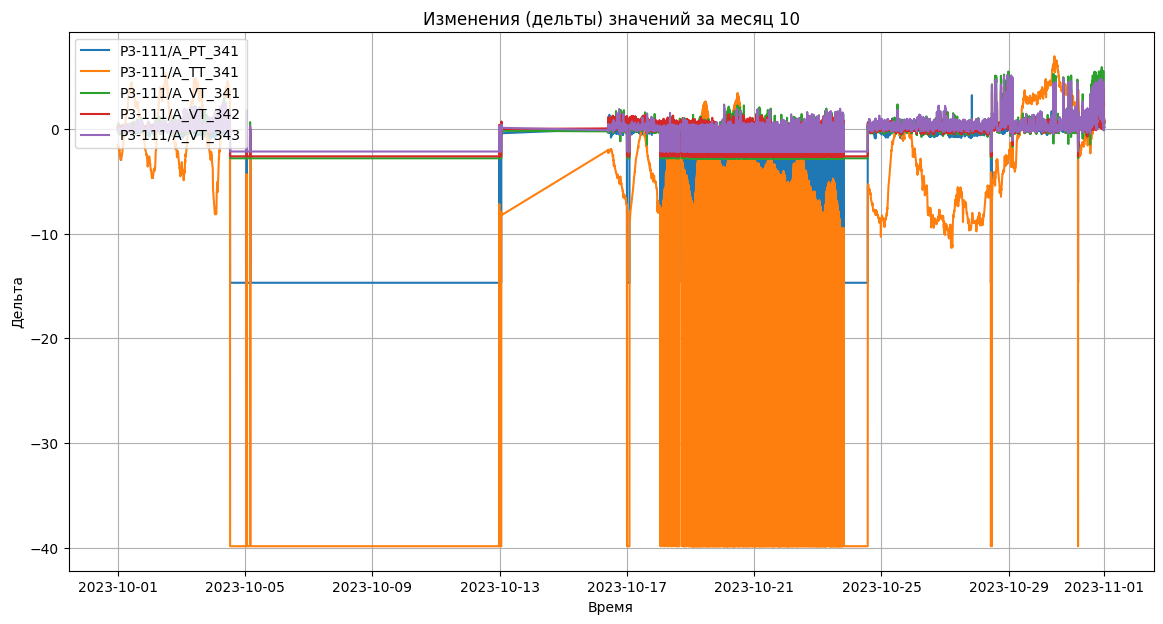

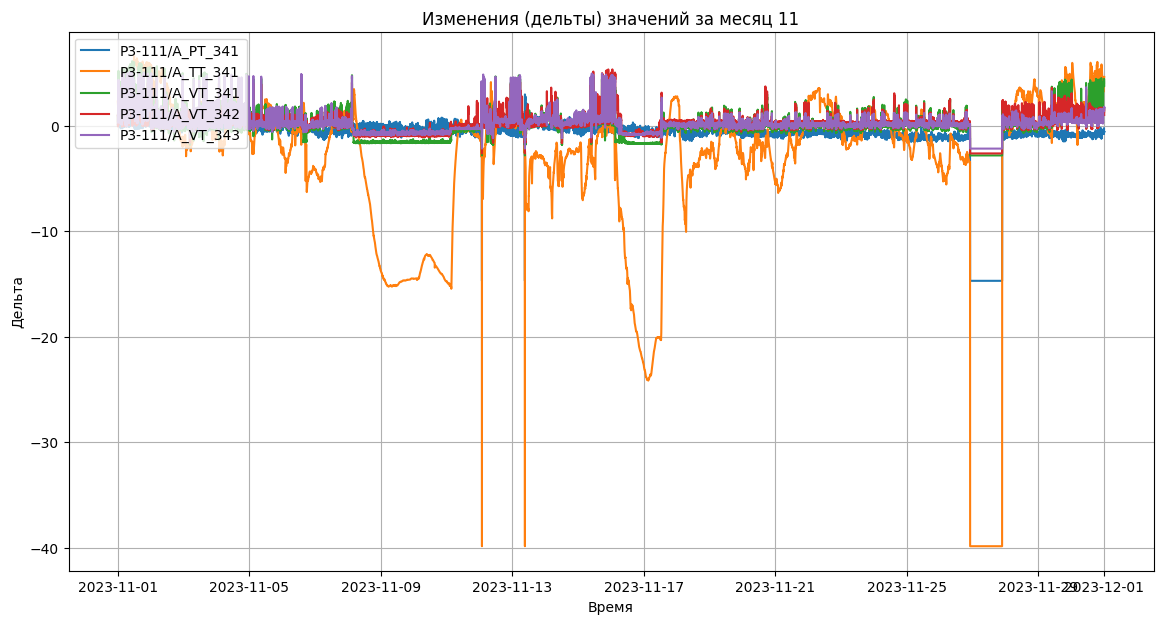

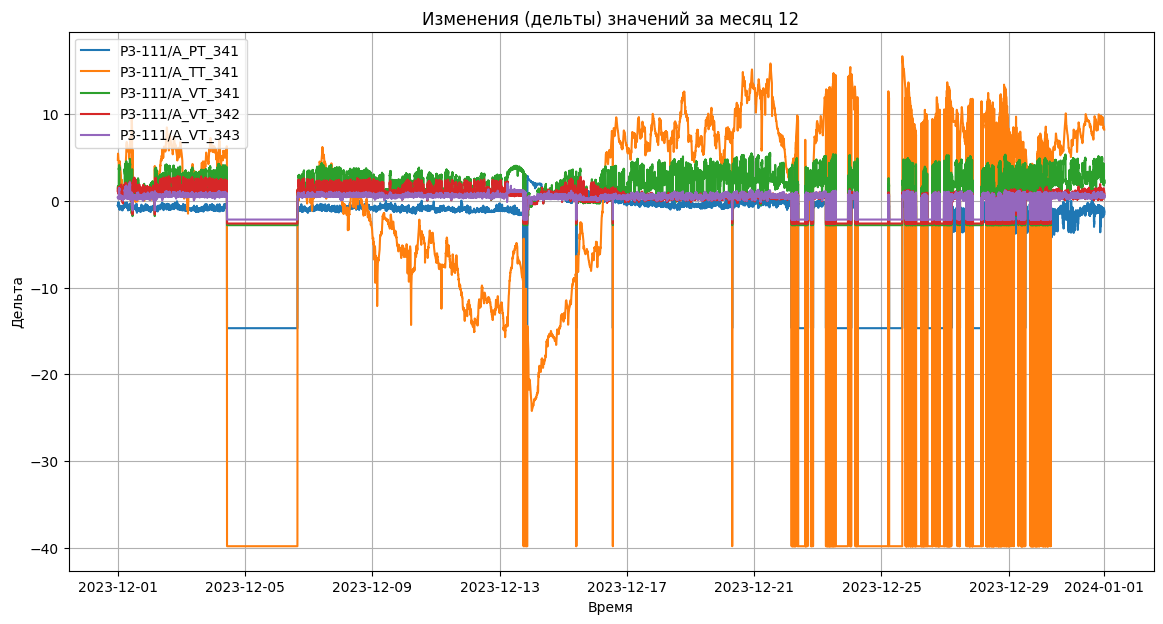

In [ ]:
import matplotlib.pyplot as plt

# Функция для визуализации дельт
def visualize_deltas(deltas, month):
    plt.figure(figsize=(14, 7))
    for column in deltas.columns:
        plt.plot(deltas.index, deltas[column], label=column)

    plt.title(f'Изменения (дельты) значений за месяц {month}')
    plt.xlabel('Время')
    plt.ylabel('Дельта')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Визуализация для каждого месяца
for month in months:
    delta_path = f'C:\\Users\\Admin\\Desktop\\Питон\\Nordal\\P-111\\P3-111_A_deltas_month_{month}.csv'
    deltas = pd.read_csv(delta_path, index_col='time', parse_dates=True)
    visualize_deltas(deltas, month)


In [ ]:
import pandas as pd

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append(dict_row['pumps_falure'])
        if failures_for_month:
            failure_indicators.append(', '.join(failures_for_month))
        else:
            failure_indicators.append('No failure')
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Сохранение результатов
results_df = pd.DataFrame({
    'month': monthly_deltas.index,
    'failure_indicators': failure_indicators
})
results_df.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_indicators.csv', index=False)

# Вывод результатов в консоль
print("Возможные неисправности по месяцам:")
print(results_df)


Возможные неисправности по месяцам:
       month                                 failure_indicators
0 2023-08-31                                         No failure
1 2023-09-30                                         No failure
2 2023-10-31                                         No failure
3 2023-11-30  Не Выдержаны Допуски Рабочего Колеса, Износ Со...
4 2023-12-31  Износ вала, Износ Рабочего Колеса, Повреждение...


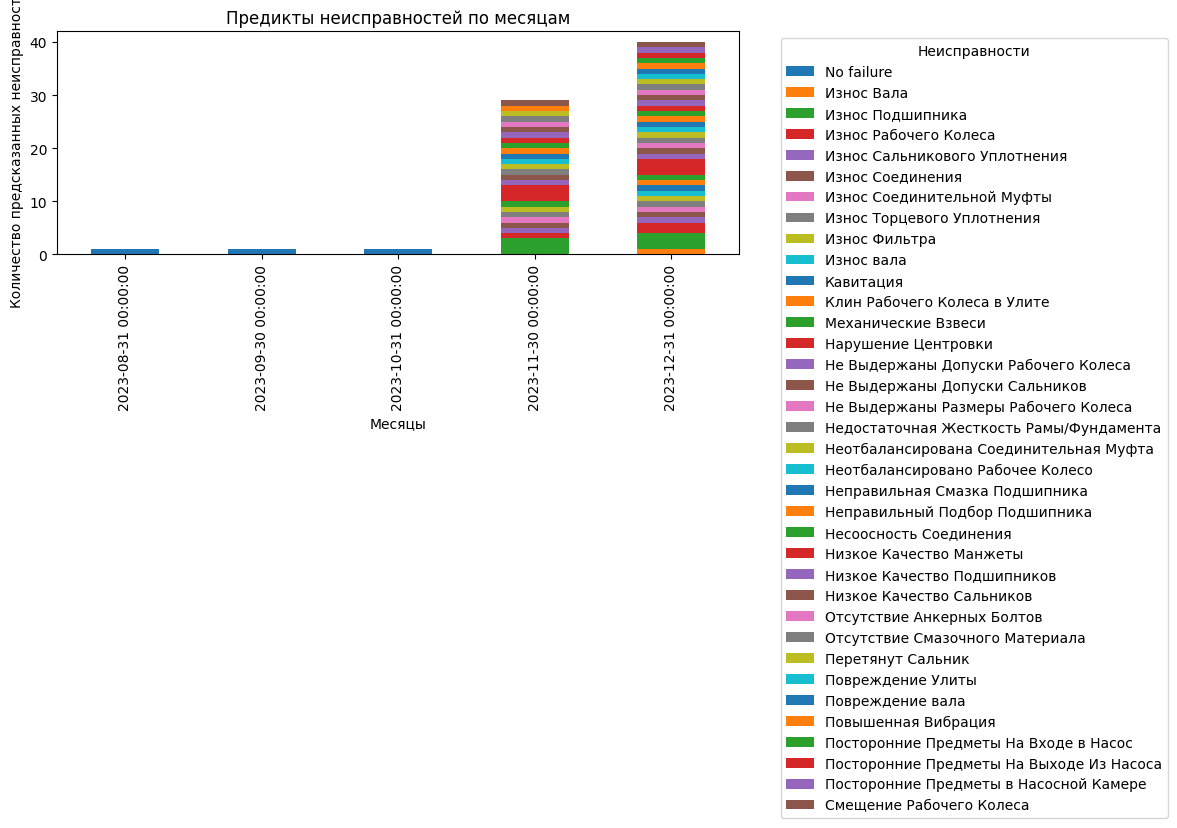

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из сохраненного CSV
results_df = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_indicators.csv')
results_df['month'] = pd.to_datetime(results_df['month'])

# Подготовка данных для визуализации
results_df['failure_indicators'] = results_df['failure_indicators'].str.split(', ')
results_df = results_df.explode('failure_indicators')
failure_counts = results_df.groupby(['month', 'failure_indicators']).size().unstack(fill_value=0)

# Добавляем столбец для месяцев без неисправностей
if 'No failure' not in failure_counts.columns:
    failure_counts['No failure'] = 0
failure_counts['No failure'] += (failure_counts.sum(axis=1) == 0)

# Построение графика
failure_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Месяцы')
plt.ylabel('Количество предсказанных неисправностей')
plt.title('Предикты неисправностей по месяцам')
plt.legend(title='Неисправности', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_plot.png')

# Отображение графика
plt.show()


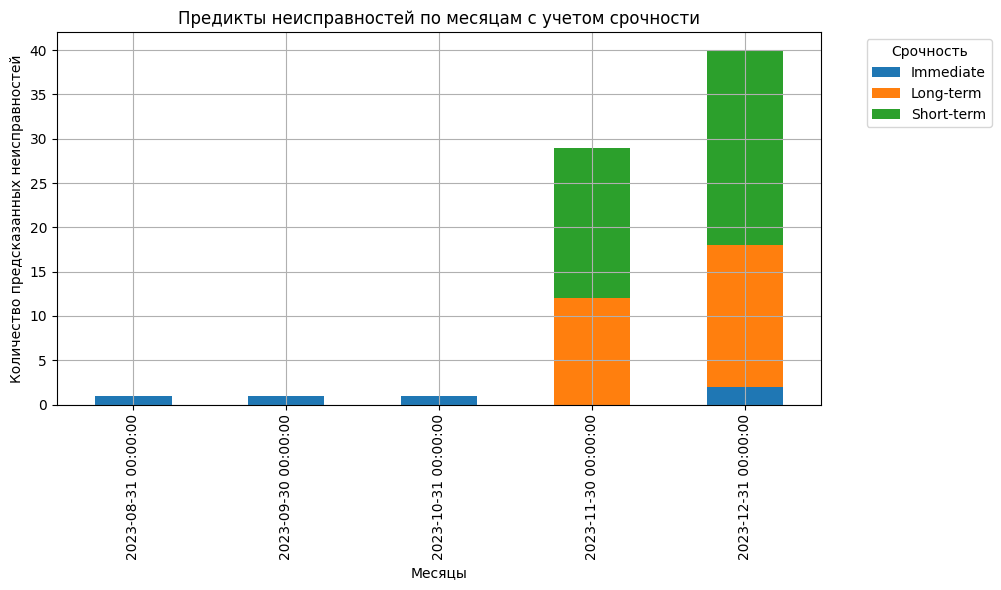

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append((dict_row['pumps_falure'], dict_row['duration']))
        if failures_for_month:
            failure_indicators.append(failures_for_month)
        else:
            failure_indicators.append([('No failure', 0)])
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Преобразование данных для визуализации
visualization_data = []
for month, failures in zip(monthly_deltas.index, failure_indicators):
    for failure, duration in failures:
        if duration <= 0.001:
            urgency = 'Immediate'
        elif duration <= 2:
            urgency = 'Short-term'
        else:
            urgency = 'Long-term'
        visualization_data.append({'month': month, 'failure': failure, 'duration': duration, 'urgency': urgency})

visualization_df = pd.DataFrame(visualization_data)

# Построение столбчатого графика
pivot_df = visualization_df.pivot_table(index='month', columns='urgency', values='failure', aggfunc='count', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Месяцы')
plt.ylabel('Количество предсказанных неисправностей')
plt.title('Предикты неисправностей по месяцам с учетом срочности')
plt.legend(title='Срочность', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_plot.png')

# Отображение графика
plt.show()


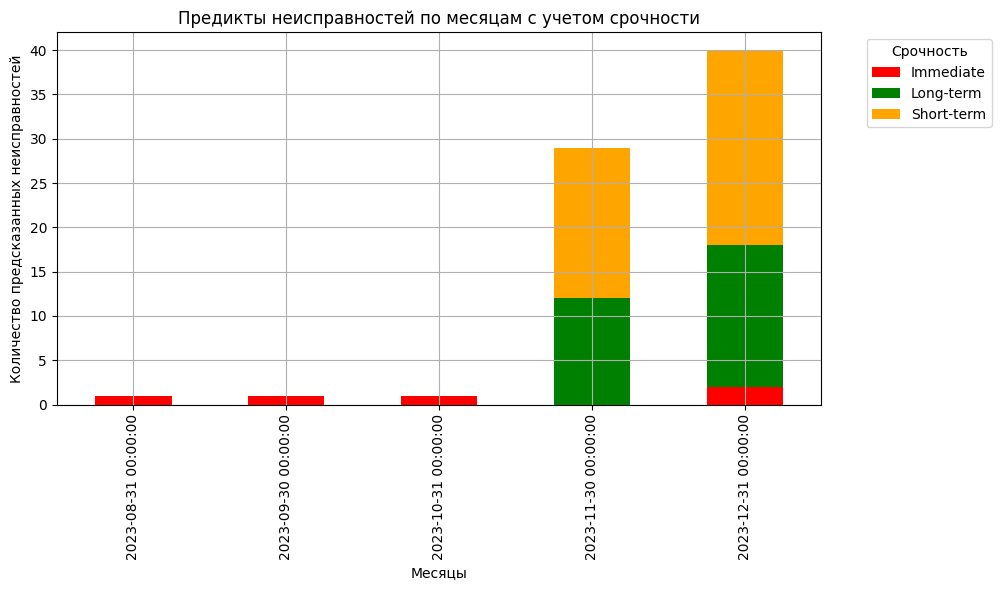

Срочные неисправности (Immediate): No failure, Посторонние Предметы в Насосной Камере, Посторонние Предметы На Входе в Насос
Краткосрочные неисправности (Short-term): Не Выдержаны Допуски Рабочего Колеса, Нарушение Центровки, Перетянут Сальник, Износ Сальникового Уплотнения, Износ Торцевого Уплотнения, Не Выдержаны Допуски Сальников, Низкое Качество Манжеты, Низкое Качество Сальников, Недостаточная Жесткость Рамы/Фундамента, Отсутствие Анкерных Болтов, Механические Взвеси, Отсутствие Смазочного Материала, Неправильный Подбор Подшипника, Износ Подшипника, Низкое Качество Подшипников , Повышенная Вибрация , Повреждение Улиты, Посторонние Предметы На Выходе Из Насоса, Не Выдержаны Размеры Рабочего Колеса, Кавитация, Повреждение вала
Долгосрочные неисправности (Long-term): Износ Соединения, Смещение Рабочего Колеса, Износ Фильтра, Износ Рабочего Колеса, Износ Подшипника, Нарушение Центровки, Износ Соединительной Муфты, Несоосность Соединения, Неотбалансировано Рабочее Колесо, Неотбалансиро

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append((dict_row['pumps_falure'], dict_row['duration']))
        if failures_for_month:
            failure_indicators.append(failures_for_month)
        else:
            failure_indicators.append([('No failure', 0)])
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Преобразование данных для визуализации
visualization_data = []
for month, failures in zip(monthly_deltas.index, failure_indicators):
    for failure, duration in failures:
        if duration <= 0.001:
            urgency = 'Immediate'
        elif duration <= 2:
            urgency = 'Short-term'
        else:
            urgency = 'Long-term'
        visualization_data.append({'month': month, 'failure': failure, 'duration': duration, 'urgency': urgency})

visualization_df = pd.DataFrame(visualization_data)

# Построение столбчатого графика
pivot_df = visualization_df.pivot_table(index='month', columns='urgency', values='failure', aggfunc='count', fill_value=0)

# Определение цветов
colors = {'Immediate': 'red', 'Short-term': 'orange', 'Long-term': 'green'}

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors.get(x, '#333333') for x in pivot_df.columns])

plt.xlabel('Месяцы')
plt.ylabel('Количество предсказанных неисправностей')
plt.title('Предикты неисправностей по месяцам с учетом срочности')
plt.legend(title='Срочность', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_plot.png')

# Отображение графика
plt.show()

# Создание CSV файла с аналитикой
visualization_df.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_analysis.csv', index=False)

# Создание пояснений
immediate_failures = visualization_df[visualization_df['urgency'] == 'Immediate']['failure'].unique()
short_term_failures = visualization_df[visualization_df['urgency'] == 'Short-term']['failure'].unique()
long_term_failures = visualization_df[visualization_df['urgency'] == 'Long-term']['failure'].unique()

# Печать пояснений
print("Срочные неисправности (Immediate):", ", ".join(immediate_failures))
print("Краткосрочные неисправности (Short-term):", ", ".join(short_term_failures))
print("Долгосрочные неисправности (Long-term):", ", ".join(long_term_failures))


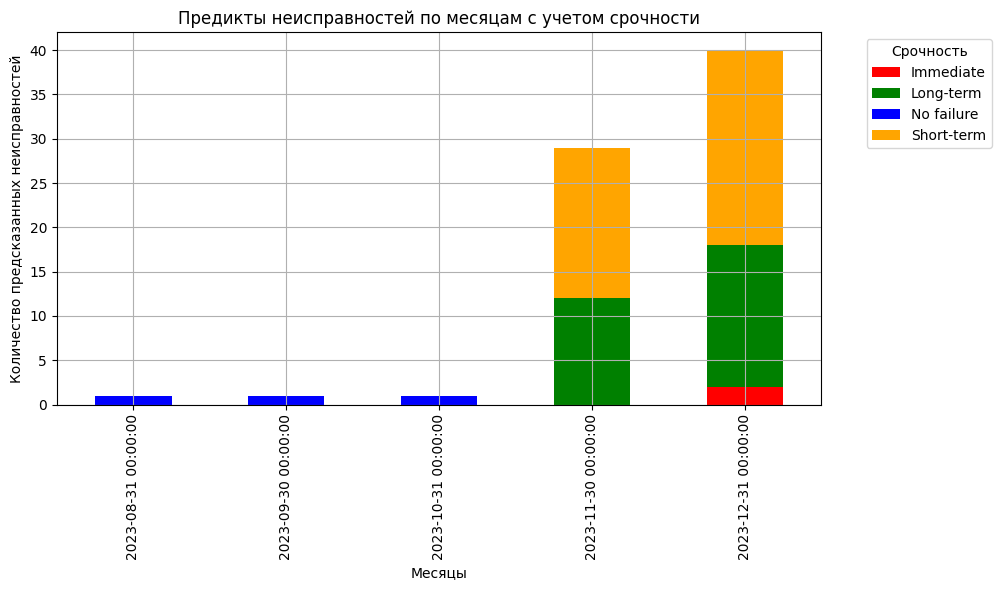

Срочные неисправности (Immediate): Посторонние Предметы в Насосной Камере, Посторонние Предметы На Входе в Насос
Краткосрочные неисправности (Short-term): Не Выдержаны Допуски Рабочего Колеса, Нарушение Центровки, Перетянут Сальник, Износ Сальникового Уплотнения, Износ Торцевого Уплотнения, Не Выдержаны Допуски Сальников, Низкое Качество Манжеты, Низкое Качество Сальников, Недостаточная Жесткость Рамы/Фундамента, Отсутствие Анкерных Болтов, Механические Взвеси, Отсутствие Смазочного Материала, Неправильный Подбор Подшипника, Износ Подшипника, Низкое Качество Подшипников , Повышенная Вибрация , Повреждение Улиты, Посторонние Предметы На Выходе Из Насоса, Не Выдержаны Размеры Рабочего Колеса, Кавитация, Повреждение вала
Долгосрочные неисправности (Long-term): Износ Соединения, Смещение Рабочего Колеса, Износ Фильтра, Износ Рабочего Колеса, Износ Подшипника, Нарушение Центровки, Износ Соединительной Муфты, Несоосность Соединения, Неотбалансировано Рабочее Колесо, Неотбалансирована Соедини

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append((dict_row['pumps_falure'], dict_row['duration']))
        if failures_for_month:
            failure_indicators.append(failures_for_month)
        else:
            failure_indicators.append([('No failure', 0)])
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Преобразование данных для визуализации
visualization_data = []
for month, failures in zip(monthly_deltas.index, failure_indicators):
    for failure, duration in failures:
        if failure == 'No failure':
            urgency = 'No failure'
        elif duration <= 0.001:
            urgency = 'Immediate'
        elif duration <= 2:
            urgency = 'Short-term'
        else:
            urgency = 'Long-term'
        visualization_data.append({'month': month, 'failure': failure, 'duration': duration, 'urgency': urgency})

visualization_df = pd.DataFrame(visualization_data)

# Построение столбчатого графика
pivot_df = visualization_df.pivot_table(index='month', columns='urgency', values='failure', aggfunc='count', fill_value=0)

# Определение цветов
colors = {'Immediate': 'red', 'Short-term': 'orange', 'Long-term': 'green', 'No failure': 'blue'}

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors.get(x, '#333333') for x in pivot_df.columns])

plt.xlabel('Месяцы')
plt.ylabel('Количество предсказанных неисправностей')
plt.title('Предикты неисправностей по месяцам с учетом срочности')
plt.legend(title='Срочность', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_plot.png')

# Отображение графика
plt.show()

# Создание CSV файла с аналитикой
visualization_df.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\failure_predictions_analysis.csv', index=False)

# Создание пояснений
immediate_failures = visualization_df[visualization_df['urgency'] == 'Immediate']['failure'].unique()
short_term_failures = visualization_df[visualization_df['urgency'] == 'Short-term']['failure'].unique()
long_term_failures = visualization_df[visualization_df['urgency'] == 'Long-term']['failure'].unique()

# Печать пояснений
print("Срочные неисправности (Immediate):", ", ".join(immediate_failures))
print("Краткосрочные неисправности (Short-term):", ", ".join(short_term_failures))
print("Долгосрочные неисправности (Long-term):", ", ".join(long_term_failures))
print("Месяцы без неисправностей (No failure):")
for month in pivot_df.index[pivot_df['No failure'] > 0]:
    print(month.strftime('%Y-%m'))


**Подсчет износа**

**Для начала почитаем износ только по нашим обнаруженным тенденциям к неисправности.**

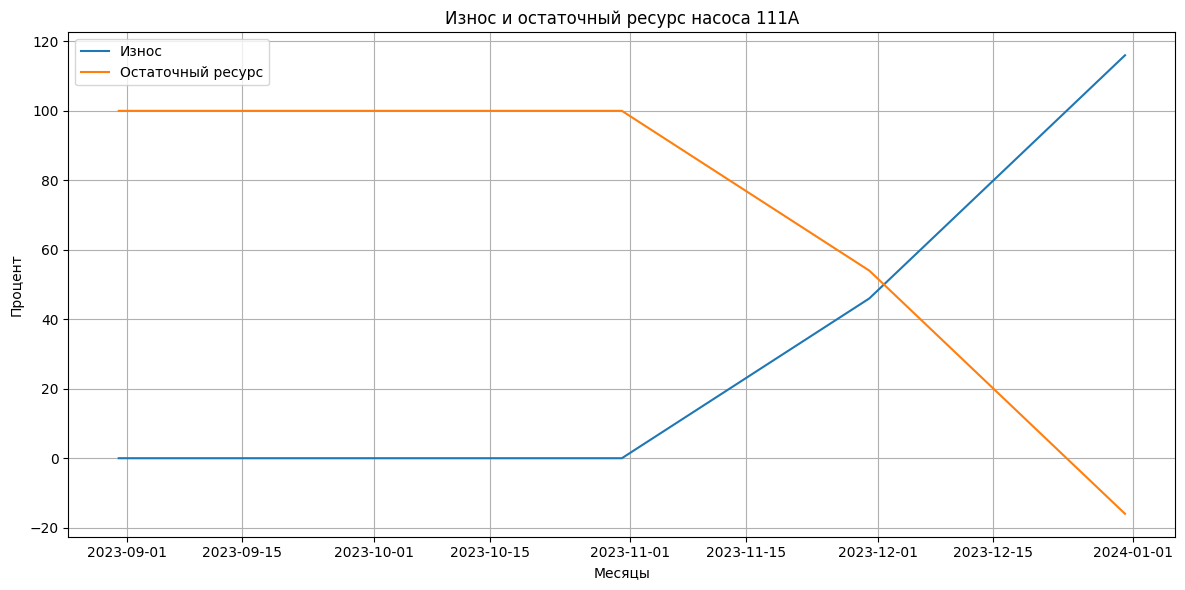

Срочные неисправности (Immediate): Посторонние Предметы в Насосной Камере, Посторонние Предметы На Входе в Насос
Краткосрочные неисправности (Short-term): Не Выдержаны Допуски Рабочего Колеса, Нарушение Центровки, Перетянут Сальник, Износ Сальникового Уплотнения, Износ Торцевого Уплотнения, Не Выдержаны Допуски Сальников, Низкое Качество Манжеты, Низкое Качество Сальников, Недостаточная Жесткость Рамы/Фундамента, Отсутствие Анкерных Болтов, Механические Взвеси, Отсутствие Смазочного Материала, Неправильный Подбор Подшипника, Износ Подшипника, Низкое Качество Подшипников , Повышенная Вибрация , Повреждение Улиты, Посторонние Предметы На Выходе Из Насоса, Не Выдержаны Размеры Рабочего Колеса, Кавитация, Повреждение вала
Долгосрочные неисправности (Long-term): Износ Соединения, Смещение Рабочего Колеса, Износ Фильтра, Износ Рабочего Колеса, Износ Подшипника, Нарушение Центровки, Износ Соединительной Муфты, Несоосность Соединения, Неотбалансировано Рабочее Колесо, Неотбалансирована Соедини

In [ ]:
import pandas as pd

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append((dict_row['pumps_falure'], dict_row['duration']))
        if failures_for_month:
            failure_indicators.append(failures_for_month)
        else:
            failure_indicators.append([('No failure', 0)])
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Преобразование данных для визуализации и расчета износа
visualization_data = []
for month, failures in zip(monthly_deltas.index, failure_indicators):
    for failure, duration in failures:
        if failure == 'No failure':
            urgency = 'No failure'
        elif duration <= 0.001:
            urgency = 'Immediate'
        elif duration <= 2:
            urgency = 'Short-term'
        else:
            urgency = 'Long-term'
        visualization_data.append({'month': month, 'failure': failure, 'duration': duration, 'urgency': urgency})

visualization_df = pd.DataFrame(visualization_data)

# Начальное значение износа
initial_wear = 0
wear_increase = {
    'Immediate': 5,   # Срочные неисправности
    'Short-term': 2,  # Краткосрочные неисправности
    'Long-term': 1,   # Долгосрочные неисправности
}

# Расчет износа по месяцам
wear_data = []
current_wear = initial_wear

for month in monthly_deltas.index:
    month_data = visualization_df[visualization_df['month'] == month]
    for urgency in ['Immediate', 'Short-term', 'Long-term']:
        count = month_data[month_data['urgency'] == urgency].shape[0]
        current_wear += count * wear_increase.get(urgency, 0)
    wear_data.append({'month': month, 'wear': current_wear})

wear_df = pd.DataFrame(wear_data)
wear_df['residual_life'] = 100 - wear_df['wear']

# Построение графика износа и остаточного ресурса
plt.figure(figsize=(12, 6))
plt.plot(wear_df['month'], wear_df['wear'], label='Износ')
plt.plot(wear_df['month'], wear_df['residual_life'], label='Остаточный ресурс')
plt.xlabel('Месяцы')
plt.ylabel('Процент')
plt.title('Износ и остаточный ресурс насоса 111А')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\wear_and_residual_life.png')

# Отображение графика
plt.show()

# Сохранение данных в CSV файл
wear_df.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\wear_and_residual_life.csv', index=False)

# Создание пояснений
immediate_failures = visualization_df[visualization_df['urgency'] == 'Immediate']['failure'].unique()
short_term_failures = visualization_df[visualization_df['urgency'] == 'Short-term']['failure'].unique()
long_term_failures = visualization_df[visualization_df['urgency'] == 'Long-term']['failure'].unique()

# Печать пояснений
print("Срочные неисправности (Immediate):", ", ".join(immediate_failures))
print("Краткосрочные неисправности (Short-term):", ", ".join(short_term_failures))
print("Долгосрочные неисправности (Long-term):", ", ".join(long_term_failures))
print("Месяцы без неисправностей (No failure):")
for month in monthly_deltas.index[wear_df['wear'] == initial_wear]:
    print(month.strftime('%Y-%m'))


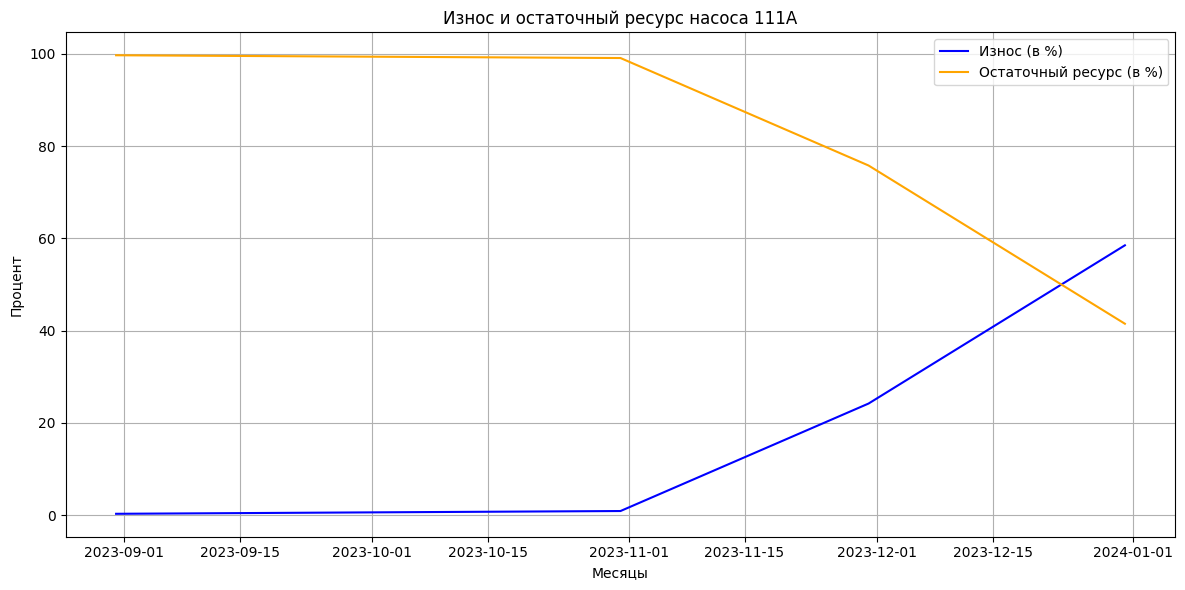

Срочные неисправности (Immediate): Посторонние Предметы в Насосной Камере, Посторонние Предметы На Входе в Насос
Краткосрочные неисправности (Short-term): Не Выдержаны Допуски Рабочего Колеса, Нарушение Центровки, Перетянут Сальник, Износ Сальникового Уплотнения, Износ Торцевого Уплотнения, Не Выдержаны Допуски Сальников, Низкое Качество Манжеты, Низкое Качество Сальников, Недостаточная Жесткость Рамы/Фундамента, Отсутствие Анкерных Болтов, Механические Взвеси, Отсутствие Смазочного Материала, Неправильный Подбор Подшипника, Износ Подшипника, Низкое Качество Подшипников , Повышенная Вибрация , Повреждение Улиты, Посторонние Предметы На Выходе Из Насоса, Не Выдержаны Размеры Рабочего Колеса, Кавитация, Повреждение вала
Долгосрочные неисправности (Long-term): Износ Соединения, Смещение Рабочего Колеса, Износ Фильтра, Износ Рабочего Колеса, Износ Подшипника, Нарушение Центровки, Износ Соединительной Муфты, Несоосность Соединения, Неотбалансировано Рабочее Колесо, Неотбалансирована Соедини

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data_path = r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_classified.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Загрузка словаря неисправностей
df_dict = pd.read_csv(r"C:\Users\Admin\Desktop\Питон\Nordal\P-111\failures_dict.csv")

# Функция для расчета средних дельт в процентах
def calculate_monthly_deltas(data, quiet_month_data):
    monthly_means = data.resample('M').mean()
    quiet_month_mean = quiet_month_data.mean()
    deltas = (monthly_means - quiet_month_mean) / quiet_month_mean * 100
    return deltas

# Выбираем данные самого тихого месяца (уже сохраненные ранее)
quiet_month_data = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\P3-111_A_quiet_month.csv')
quiet_month_data['time'] = pd.to_datetime(quiet_month_data['time'])
quiet_month_data.set_index('time', inplace=True)

# Рассчитываем дельты за каждый месяц
monthly_deltas = calculate_monthly_deltas(data, quiet_month_data)

# Сравниваем с пороговыми значениями из словаря неисправностей
def compare_with_dict(deltas, df_dict):
    failure_indicators = []
    for _, row in deltas.iterrows():
        failures_for_month = []
        for index, dict_row in df_dict.iterrows():
            condition = (
                (row['P3-111/A_PT_341'] > dict_row['pt_changes']) |
                (row['P3-111/A_TT_341'] > dict_row['tt_changes']) |
                (row['P3-111/A_VT_341'] > dict_row['vt_motor_changes_high']) |
                (row['P3-111/A_VT_342'] > dict_row['vt_pump_changes_high']) |
                (row['P3-111/A_VT_343'] > dict_row['vt_pump_changes_high.1'])
            )
            if condition:
                failures_for_month.append((dict_row['pumps_falure'], dict_row['duration']))
        if failures_for_month:
            failure_indicators.append(failures_for_month)
        else:
            failure_indicators.append([('No failure', 0)])
    return failure_indicators

failure_indicators = compare_with_dict(monthly_deltas, df_dict)

# Преобразование данных для визуализации и расчета износа
visualization_data = []
for month, failures in zip(monthly_deltas.index, failure_indicators):
    for failure, duration in failures:
        if failure == 'No failure':
            urgency = 'No failure'
        elif duration <= 0.001:
            urgency = 'Immediate'
        elif duration <= 2:
            urgency = 'Short-term'
        else:
            urgency = 'Long-term'
        visualization_data.append({'month': month, 'failure': failure, 'duration': duration, 'urgency': urgency})

visualization_df = pd.DataFrame(visualization_data)

# Начальное значение износа и другие параметры
initial_wear = 0
max_hours = 26280  # 3 года
hours_per_month = 720
pp_hours = 8760
wash_increase = 0.1
stop_decrease = 0.3

wear_increase = {
    'Immediate': 2,   # Срочные неисправности
    'Short-term': 1,  # Краткосрочные неисправности
    'Long-term': 0.5, # Долгосрочные неисправности
}

# Расчет износа по месяцам
wear_data = []
current_wear = initial_wear
current_hours = 0
remaining_hours = max_hours

for month in monthly_deltas.index:
    month_data = visualization_df[visualization_df['month'] == month]
    current_hours += hours_per_month

    # Проверка на ППР
    if current_hours >= pp_hours:
        current_hours = 0
        remaining_hours += pp_hours * 0.1  # ППР увеличивает ресурс на 10% от предельных моточасов
        if remaining_hours > max_hours:
            remaining_hours = max_hours

    # Промывка каждую среду
    if month.weekday() == 2:
        remaining_hours += max_hours * (wash_increase / 100)
        if remaining_hours > max_hours:
            remaining_hours = max_hours

    # Учёт износа от остановок
    if month.weekday() != 2:
        current_wear += stop_decrease
        remaining_hours -= max_hours * (stop_decrease / 100)
        if remaining_hours < 0:
            remaining_hours = 0

    for urgency in ['Immediate', 'Short-term', 'Long-term']:
        count = month_data[month_data['urgency'] == urgency].shape[0]
        current_wear += count * wear_increase.get(urgency, 0)
        remaining_hours -= max_hours * (count * wear_increase.get(urgency, 0) / 100)
        if remaining_hours < 0:
            remaining_hours = 0

    wear_data.append({'month': month, 'wear': current_wear, 'remaining_hours': remaining_hours})

wear_df = pd.DataFrame(wear_data)
wear_df['residual_life'] = (wear_df['remaining_hours'] / max_hours) * 100

# Построение графика износа и остаточного ресурса
plt.figure(figsize=(12, 6))
plt.plot(wear_df['month'], wear_df['wear'], label='Износ (в %)', color='blue')
plt.plot(wear_df['month'], wear_df['residual_life'], label='Остаточный ресурс (в %)', color='orange')
plt.xlabel('Месяцы')
plt.ylabel('Процент')
plt.title('Износ и остаточный ресурс насоса 111А')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Сохранение графика
plt.savefig(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\wear_and_residual_life.png')

# Отображение графика
plt.show()

# Сохранение данных в CSV файл
wear_df.to_csv(r'C:\Users\Admin\Desktop\Питон\Nordal\P-111\wear_and_residual_life.csv', index=False)

# Создание пояснений
immediate_failures = visualization_df[visualization_df['urgency'] == 'Immediate']['failure'].unique()
short_term_failures = visualization_df[visualization_df['urgency'] == 'Short-term']['failure'].unique()
long_term_failures = visualization_df[visualization_df['urgency'] == 'Long-term']['failure'].unique()

# Печать пояснений
print("Срочные неисправности (Immediate):", ", ".join(immediate_failures))
print("Краткосрочные неисправности (Short-term):", ", ".join(short_term_failures))
print("Долгосрочные неисправности (Long-term):", ", ".join(long_term_failures))
print("Месяцы без неисправностей (No failure):")
for month in monthly_deltas.index[wear_df['wear'] == initial_wear]:
    print(month.strftime('%Y-%m'))

# Выводы по износу и остаточному ресурсу
print("\nИзнос и остаточный ресурс по месяцам:")
for index, row in wear_df.iterrows():
    print(f"Месяц: {row['month'].strftime('%Y-%m')}, Износ: {row['wear']:.2f}%, Остаточный ресурс: {row['residual_life']:.2f}%, Оставшиеся часы: {row['remaining_hours']:.2f}")
